# Figures for Thermag VIII Poster

In [1]:
from pathlib import Path
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize, differential_evolution, basinhopping
from scipy.interpolate import interp1d
from pandas import Series, DataFrame
import pandas as pd

import teslamax
from teslamax import TeslaMaxGeometry, TeslaMaxPreDesign, TeslaMaxModel

import nemplot
from nemplot import nemplot_parameters

from IPython.display import display, HTML

In [2]:
DICT_LINES = 19
N_POINTS_LINEPLOT = 2000

B_HIGH_LIMIT = 1.2

TESLAMAX_PATH = Path.home() / "code" / "TeslaMax"

PLAYGROUND_DIR = "teslamax-play"

RAMP_RESULTS_DIR_FMT = "ramp_Bh_%d_FM_%d"

TESLAMAX_MPH_DIR = TESLAMAX_PATH / "java"

TESLAMAX_FILENAME = "TeslaMax_Model"
TESLAMAX_FILE_EXT = "mph"

TESLAMAX_FILE_STR = str(TESLAMAX_MPH_DIR / (TESLAMAX_FILENAME + "." + TESLAMAX_FILE_EXT))


TESLAMAX_PLAYGROUND = TESLAMAX_PATH / PLAYGROUND_DIR

In [3]:
os.chdir(str(Path.home() / "code" / "TeslaMax"))

In [4]:
os.getcwd()

'C:\\Users\\fabiofortkamp\\code\\TeslaMax'

In [5]:
def filter_table_from_column(table,column,value):
    """
    Return a view into the 'table' DataFrame, selecting only the rows where
    'column' equals 'value'
    """
    
    return table[table[column] == value]

In [6]:
B_LABEL = r'$B\ped{h}\,[\si{\tesla}]$'
Q_LABEL = r'$\qc\,[\si{\watt}]$'
PHI_LABEL = r'$\Phi$'
H_REG_LABEL = r'$H\,[\si{\milli\meter}]$'
F_B_LABEL = r'$F\ped{B}\,[\si{\percent}]$'
F_M_LABEL = r'$F\ped{M}\,[\si{\percent}]$'
H_MAX_LABEL = r'$\overline{B}\ped{max}\,[\si{\tesla}]$'
COP_LABEL = r'$\cop$'

if sys.platform == 'darwin':
    PAPER_FOLDER = Path("/Volumes") / \
                        "GoogleDrive" / \
                        "My Drive"/ \
                        "PoloMag"/ \
                        "___PoloMag-Publico"/ \
                        "Conferences"/ \
                        "Themag_VIII_2018"/ \
                        "Posters_Thermag_VIII_2018"/ \
                        "Fortkamp_Integrated_Design_Poster"
elif sys.platform == 'win32':
    PAPER_FOLDER = Path("G:") / \
                        "Meu Drive"/ \
                        "PoloMag"/ \
                        "___PoloMag-Publico"/ \
                        "Conferences"/ \
                        "Themag_VIII_2018"/ \
                        "Posters_Thermag_VIII_2018"/ \
                        "Fortkamp_Integrated_Design_Poster"                      
                        
nemplot.set_main_path(PAPER_FOLDER)
nemplot.set_figures_dir('.')
nemplot.set_figsize_cm(20)
nemplot.set_fontsize(24)
nemplot.set_plot_extension('.png')
nemplot.set_dpi(1000)
nemplot.set_latex_font('Times')


In [7]:
PAPER_FOLDER.exists()

True

## Ramp profile

## Plotting the ramp profile

In [8]:
def calculate_ramp_profile(phi, B_low, B_high, field_fraction):
    """
    Calculate the value of the two-pole ramp magnetic profile at angular position 'phi' (in degrees),
    where the profile oscillates from 'B_low' to 'B_high', with a field fraction of 'field_fraction' 
    (fraction of the cycle where the field is at its highest)
    
    """

    tau = 360
    tau_M = field_fraction * tau
    
    tau_R = 1.0/4 * (tau - 2*tau_M)
    
    tan_theta_r = (B_high - B_low) / (2*tau_R)
        
    initial_ascent_region = (phi < tau_R )
    
    high_region = np.logical_and((phi >= tau_R ),(phi <= (tau/2 - tau_R)))

    descent_region = np.logical_and((phi > (tau/2 - tau_R) ),(phi < (tau/2 + tau_R)))
    
    
    final_ascent_region = (phi > (tau - tau_R))

                 
    return np.where(initial_ascent_region,
                   (B_high+B_low)/2 + phi * tan_theta_r,
                    np.where(high_region,
                    B_high,
                   np.where(descent_region,
                           B_high - (phi - (tau/2 - tau_R))*tan_theta_r,
                           np.where(final_ascent_region,
                                   B_low + (phi - (tau - tau_R))*tan_theta_r,
                                   B_low))))


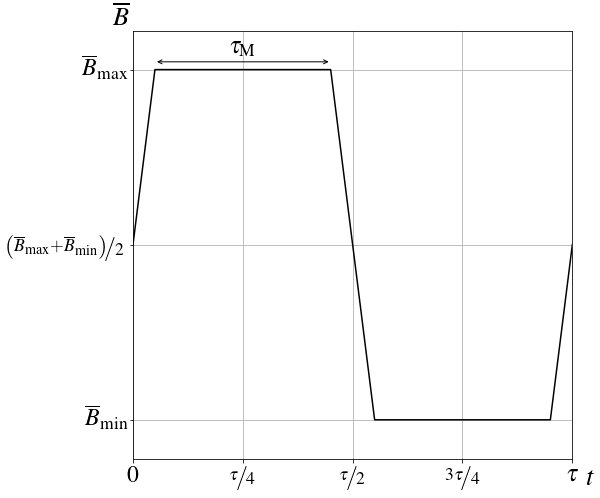

In [9]:
# only ramp

%matplotlib inline

B_max= 1.0
B_min = 0.1
F_M = 0.4

tau = 2*np.pi

time = np.linspace(0,tau,N_POINTS_LINEPLOT)
time_deg = np.rad2deg(time)

B_apl_ramp = calculate_ramp_profile(time_deg,B_min,B_max,F_M)

profile_fig, profile_axes = nemplot.create_plot()


profile_axes.plot(time,B_apl_ramp,'k-',label="Ramp")
profile_axes.set_xlim(0,np.max(time))
profile_axes.set_xticks(np.linspace(0,np.max(time),5))
profile_axes.xaxis.grid(True)
profile_axes.set_xticklabels([r'$0$', r'$\nicefrac{\tau}{4}$', r'$\nicefrac{\tau}{2}$',r'$\nicefrac{3\tau}{4}$',r'$\tau$'])

profile_axes.set_yticks([B_min,(B_max+B_min)/2,B_max])
profile_axes.set_yticklabels([r'$\average{B}\ped{min}$',
                              r'$\nicefrac{\left(\average{B}\ped{max}+\average{B}\ped{min}\right)}{2}$',
                              r'$\average{B}\ped{max}$'])
profile_axes.yaxis.grid(True)

profile_axes.set_xlabel(r'$t$',
                       fontsize=1.1*nemplot_parameters["FONTSIZE"])

profile_axes.set_ylabel(r'$\average{B}$',
                       rotation='horizontal',
                       fontsize=1.1*nemplot_parameters["FONTSIZE"])

profile_axes.xaxis.set_label_coords(1.04,-0.02)
profile_axes.yaxis.set_label_coords(-0.03,1.0)

#profile_axes.legend(loc='best',fontsize=0.8*nemplot_parameters["FONTSIZE"])

profile_axes.set_ylim(0,1.1*B_max)

tau_M = F_M * tau
tau_R = 1.0/4 * (tau - 2*tau_M)

# it seems the way to create a bidiretional arrow is to create an "annotation" with an empty text,
# and using the 'arrowprops' dictionary
profile_axes.annotate("", xy=(tau_R,1.02*B_max), xytext=(tau_R+tau_M,1.02*B_max), arrowprops=dict(arrowstyle='<->'))

profile_axes.text(tau/4,1.035*B_max,r'$\tau\ped{M}$',
                  fontsize=nemplot_parameters["FONTSIZE"],
                  horizontalalignment='center')

nemplot.save_figure(profile_fig,'profile_ramp')


## AMR curve

- Fixed regenerator
- Fixed span
- Vary frequency, utilization, ramp and blow fraction
- Magn. Period = Demagn. Period
- High field Period = Low field Period
- Magn Period + High field Period = 50%

The period the AMR cycle if $\tau$, divided into a cold stage period $\tau_C$ and a hot stage period $\tau_H$, such that $\tau_c = \tau_H$.

The blow fraction $F_B$ is the fraction of the entire cycle where there is fluid blow in a given AMR bed. The cold blow period is $\tau_{CB}$ and the how blow period is $\tau_{HB}$. Because of the symmetry between the cold and hot stages:

\begin{equation}
\tau_{CB} = F_B \tau_C = \frac{1}{2} F_B \tau = \tau_{HB}
\end{equation}

The high field fraction $F_M$ is the fraction of the entire cycle where the magnetic profile stays  fully magnetized (or, due to symmetry, fully demagnetized). 

In [14]:
def plot_Qc_Rampa(table, figure_suffix=""):
    """
    Plots figures of Qc x F_M from data from the DataFrame 'table',
    adding 'figure_suffix' to the end of the filename for each figure
    
    Creates one figure for each combination of (f, Phi), with curves for constant F_b
    """

    regsim_utilizations = {0.1988: 0.2,
                          0.2982: 0.3, 
                          0.3977: 0.4,
                          0.4971: 0.5, 
                          0.5965: 0.6,
                          0.7953: 0.8,
                          0.9942: 1.0}

    
    f_vector = table['f[Hz]'].unique()
    phi_vector = table['U_HB[-]'].unique()
    F_blow_vector = table['F[%]'].unique()    
    Mag_Period = table['MagPeriod [s]'].unique()
    
    styles=['-','--','-.',':']
    

    fig_list = []
    fig_list_COP = []
    for f in f_vector:    
        
        table_f = filter_table_from_column(table,'f[Hz]',f)
        
        for phi in phi_vector:
            
            table_f_phi = filter_table_from_column(table_f,'U_HB[-]',phi) 
                
                     
            fig_Qc, axis = nemplot.create_plot(xlabel=F_M_LABEL,
                                                ylabel=Q_LABEL)
            
            fig_COP, axis_COP = nemplot.create_plot(xlabel=F_M_LABEL,
                                                    ylabel=COP_LABEL+' [-]')
                                              
            y_max = 0
                        
            i = 0
            for F_blow in F_blow_vector:

                label_text = r'$F\ped{B} = \SI{' + '%d' %(F_blow,) + r'}{\percent}$'

                table_f_phi_F = filter_table_from_column(table_f_phi,'F[%]',F_blow)

                x_vector = table_f_phi_F['FieldPeriod[s]'].values
                Qc_vector = table_f_phi_F['Qc[W]'].values
                COP_vector = table_f_phi_F['COP[-]'].values

                axis.plot(x_vector, Qc_vector, label=label_text,linestyle=styles[i],color='k')
                axis.legend(loc='best',fontsize=nemplot_parameters["FONTSIZE"])
                
                axis_COP.plot(x_vector, COP_vector, label=label_text,linestyle=styles[i],color='k')
                axis_COP.legend(loc='best',fontsize=nemplot_parameters["FONTSIZE"])
                i = i + 1
                
                for ax in [axis,axis_COP]:
                    ax.grid(True)
                    ax.set_xticks(x_vector)
                    nemplot.refine_yticks(ax,6)
          
                
            fig_list.append(fig_Qc)
            fig_list_COP.append(fig_COP)
            nemplot.save_figure(fig=fig_Qc,
                                name='Qc_FM_ramp_f_%d_Phi_%d%s' %(f,100*regsim_utilizations[phi],figure_suffix))
            nemplot.save_figure(fig=fig_COP,
                                name='COP_FM_ramp_f_%d_Phi_%d%s' %(f,100*regsim_utilizations[phi],figure_suffix))
        
        
    return fig_list,fig_list_COP

In [15]:
# Fixed parameters

FIXED_PARAMETERS_NEW = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 25e-3,
    "H[m]": 22e-3,
    "N_r[]": 8,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[mm]": 0.5e-3,
    "t_air[mm]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

([<matplotlib.figure.Figure at 0x25cbd0412e8>,
  <matplotlib.figure.Figure at 0x25cc32239b0>])

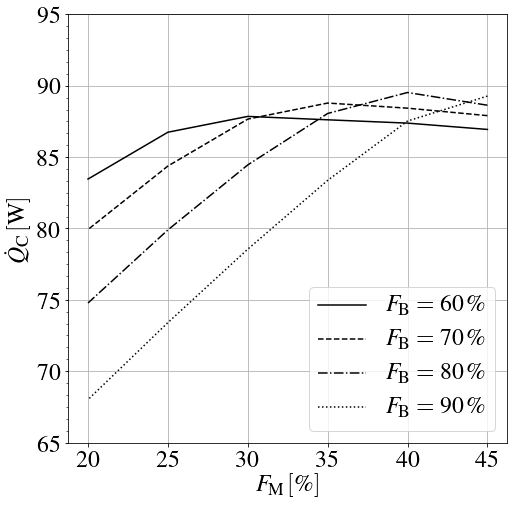

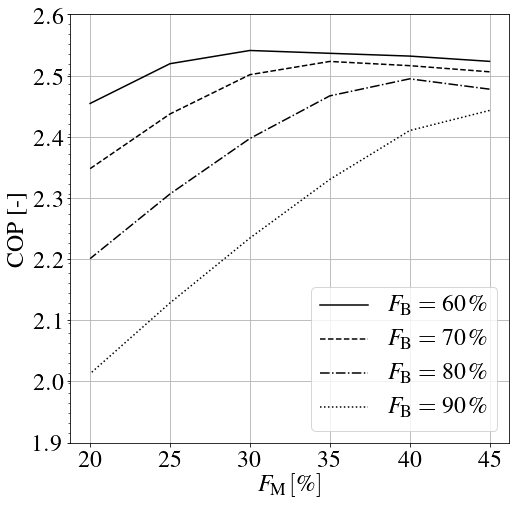

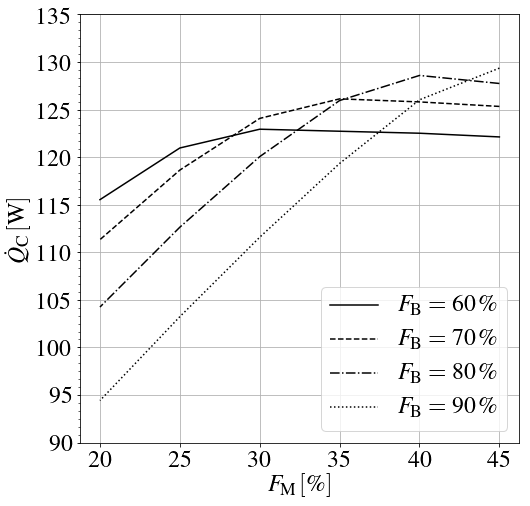

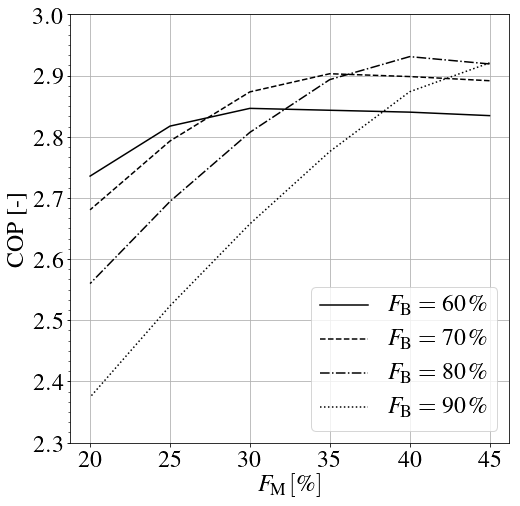

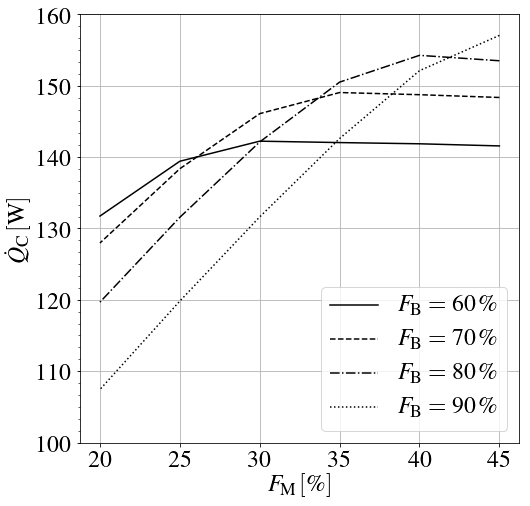

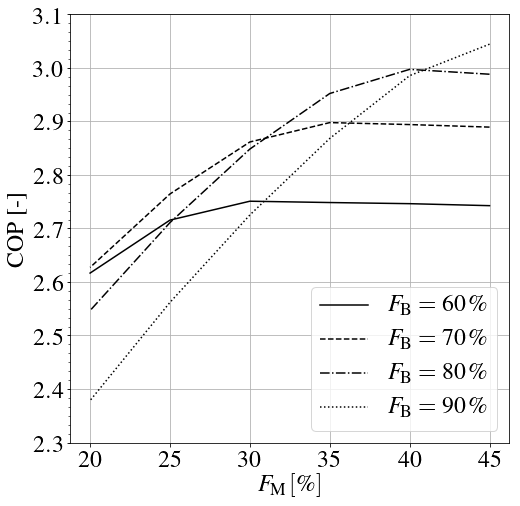

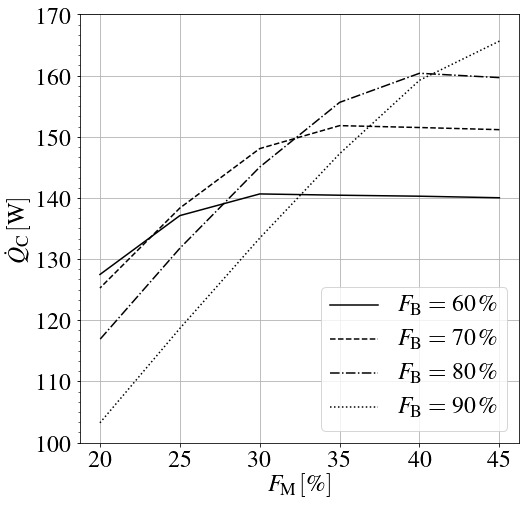

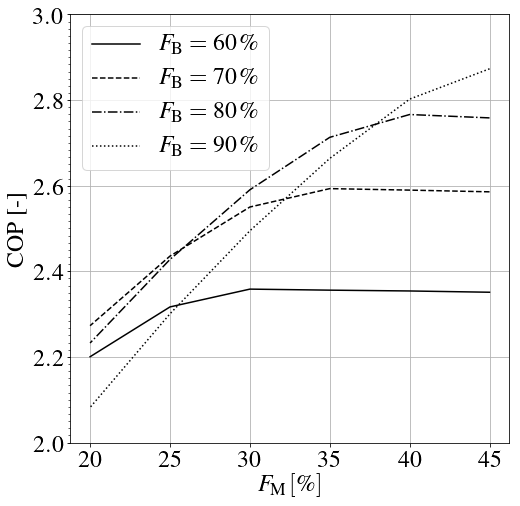

In [17]:
%matplotlib inline
table_filename = 'Slope - Perdas -35K-valv_ASCO.txt'

table = pd.read_csv(table_filename,sep='\t')

table_13 = filter_table_from_column(table,'Hmax[T]',1.3)

plot_Qc_Rampa(table_13,"_35K_1.3T")

## Optimized profile 

In [18]:
FIXED_PARAMETERS_MAGNET = {"R_i": 0.015,
                "R_o": 0.040,
                "h_fc": 0.005,
                "R_s": 105e-3,
                "h_gap": 20e-3,
                "R_e": 0.3,
                "n_II": 2,
                "n_IV": 4,
                "phi_C_II": 15,
                "phi_S_IV": 45,
                "phi_S_II": 45,
                "mu_r_II": 1.05,
                "mu_r_IV": 1.05,
              "linear_iron": 1,
              "mu_r_iron": 5e3,
             }

B_HIGH = 1.0
B_LOW = 0.0
F_M = 0.35

n_II = FIXED_PARAMETERS_MAGNET["n_II"]
n_IV = FIXED_PARAMETERS_MAGNET["n_IV"]
n = n_II + n_IV

B_rem = 1.4
B_REM = B_rem

# expand parameters to include remanence magnitudes for each segment
FIXED_PARAMETERS_MAGNET = teslamax.expand_parameters_from_remanence_array(B_rem*np.ones(n), 
                                                                      FIXED_PARAMETERS_MAGNET, 
                                                                      "B_rem")

In [19]:
def optimize_ramp(B_high,field_fraction,params):
    """
    Run the TeslaMax optimization procedure, trying to match the profile
    to a ramp profile between 0 and 'B_high' with 'field_fraction', using the
    parameters in the dictionary 'params'.
    
    Return a TeslaMaxModel object, representing the optimized magnet,
    and the value of the cost function. The TeslaMaxModel object is already populated with simulation results.
    
    The simulation results are stored in directories inside "teslamax-play".
    """
    
    tmpd = TeslaMaxPreDesign(params)
    
    target_function = teslamax.calculate_ramp_profile
    
    target_args = (B_high,B_LOW,field_fraction)

    alpha_B_rem_g = tmpd.get_optimal_remanence_angles(target_function,target_args)
    cost_function = tmpd.calculate_functional_target(alpha_B_rem_g,
                                                    target_function,
                                                    target_args)
    
    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = str(TESLAMAX_PATH / PLAYGROUND_DIR / sdir )
    
    tmm_g = TeslaMaxModel(tmpd,
                          alpha_B_rem_g,
                          path=teslamax_playground)
    tmm_g.run()
    
    return (tmm_g,cost_function)
    

In [20]:
def refine_list(original_list, factor):
    """
    Return a new list, inserting more elements between the number in 'original_list'.
    
    Assumes 'original_list' is evenly-spaced. The spacing between each element is divided by 'factor'
    
    >>>refine_list([1,2,3],factor=2)
    [1.0,1.5,2.0,2.5,3.0]
    """
    
    # calculate the original spacing between elements and refine it
    d = original_list[1] - original_list[0]
    d_refined = d / factor
        
    max_value = max(original_list)
    min_value = min(original_list)
    
    # the number of elements is the number of divisions between the limit values, plus one aditional
    n_refined = ((max_value - min_value) / d_refined) + 1
        
    return np.linspace(min_value,max_value,int(n_refined))

In [21]:
def plot_optimized_ramp(B_high,field_fraction):
    """
    Plot a comparison between the magnetic profile from the TeslaMax simulations
    and a ramp profile between 0 and 'B_high', with 'field_fraction'. The TeslaMax
    results are read from the appropriate files inside PLAYGROUND_DIR.
    
    Save the figure with the appropriate naming inside the 'figures' directory.
    """
 

    sdir = RAMP_RESULTS_DIR_FMT %(B_high*1e3, field_fraction*1e2) 
    
    teslamax_playground = TESLAMAX_PATH / PLAYGROUND_DIR / sdir
    
    profile_file = teslamax_playground / teslamax.MAGNETIC_PROFILE_FILENAME
    
    profile_fig_g, profile_axes_g = nemplot.create_plot(xlabel=r'$\phi [\si{\degree}]$',
                                                       ylabel=r'$B [\si{\tesla}]$')
    
    phi_vector_g, B_vector_g = teslamax.read_comsol_profile_data(str(profile_file))
    
    lw = 2.0
    profile_axes_g.plot(phi_vector_g,B_vector_g,linewidth=0.7*lw,color='k')
    profile_axes_g.set_xlim(0,np.max(phi_vector_g))
    profile_axes_g.set_xticks(np.linspace(0,np.max(phi_vector_g),9))
    profile_axes_g.grid(True)
    profile_axes_g.set_ylim(0,B_HIGH_LIMIT)
    
    ticks = profile_axes_g.get_yticks()
    profile_axes_g.set_yticks(refine_list(ticks,4),minor=True)
        
    #profile_axes_g.set_yticks(np.arange(0,B_HIGH_LIMIT+0.2,0.2),minor=True)
    
    B_low = 0.0
    B_inst_vector = teslamax.calculate_ramp_profile(phi_vector_g,B_high,B_LOW,field_fraction)
    profile_axes_g.plot(phi_vector_g,B_inst_vector,'--',linewidth=lw,color='gray')

    nemplot.save_figure(profile_fig_g,"profile_optimized_B_%d_FM_%d" %(B_high*1000,field_fraction*100))

### Influence of B_max, meaning of K

We test three different values of the high field to study the scale of K:

In [22]:
%%time

os.chdir(TESLAMAX_PATH)

B_high = 1.0

tmm_g_2, K_2 = optimize_ramp(B_high,F_M,FIXED_PARAMETERS_MAGNET)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.00100570874409
Wall time: 7min 2s


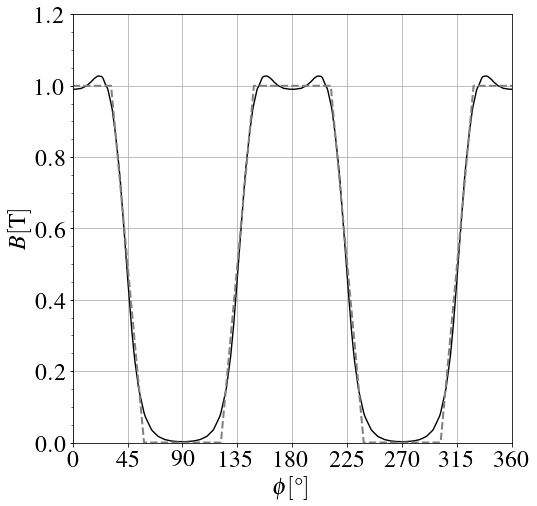

In [23]:
%matplotlib inline

plot_optimized_ramp(B_high,F_M)

In [27]:
%%time

os.chdir(TESLAMAX_PATH)

B_high = 1.15

tmm_g_2, K_2 = optimize_ramp(B_high,F_M,FIXED_PARAMETERS_MAGNET)

print("Value of the objective function:")
print(K_2)

Value of the objective function:
0.00268945488639
Wall time: 7min 41s


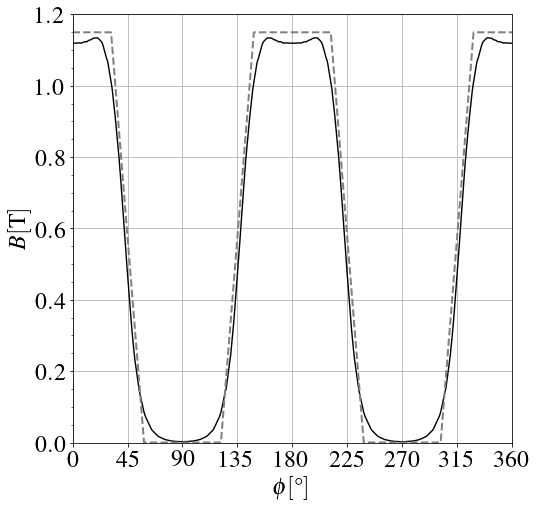

In [28]:
%matplotlib inline

plot_optimized_ramp(B_high,F_M)

## Combined map

### The estimated operating point

To define the target operating point, consider the refrigerated cabinet to be operated by the AMR system. The *cold source* is the refrigerated space inside the cabinet, and the *hot source* is the environment. In steady state, the cooling capacity must be high enough to maintain the interior at the cold temperature $T_{\mathrm{C}}$, despite heat leakage to the environment.

The experimental value of the thermal conductance of the cabinet between the interior and the environment is:

In [29]:
UA_CABINET_EXPERIMENTAL = 1.8 # W/K

and the temperature span is:

In [30]:
TARGET_TEMPERATURE_SPAN_CABINET = 20 # K 

and hence the target cooling capacity is:

In [31]:
TARGET_COOLING_CAPACITY = UA_CABINET_EXPERIMENTAL * TARGET_TEMPERATURE_SPAN_CABINET

For the heat exchangers that have been tested, a system temperature span of 20 K generate a regenerator temperature span of 35 K, so the maps of section 1 can be used.

To account for numerical errors and for the uncertainty in selecting the heat exchanger, we use a safety factor when specifying the actual target cooling capacity:

In [32]:
SAFETY_FACTOR = 3
Q_C_CRITICAL = TARGET_COOLING_CAPACITY * SAFETY_FACTOR

### Combining maps for the external radius and cooling capacity

This map shows how to select the minimum radius required to achieve a given cooling capacity, for various magnetic profiles and regenerator heights. The region above the critical cooling capacity is filled. **The radius values shown already account for the iron shell**

In [40]:
FIXED_PARAMETERS_AMR = {
    "D_p[m]": 0.35e-3,
    "L[m]": 85e-3,
    "W[m]": 30e-3,
    "H[m]": 19e-3,
    "N_r[]": 8,
    "T_H[K]": 305.5,
    "dT[K]": 35,
    "Casing material": "Stainless steel",
    "t_casing[m]": 0.5e-3,
    "t_air[m]": 1e-3,
    "N_layers[]": 3,
    "T_C_layers[K]": np.array([273,283,290]),
    "Length_fraction_layers[%]": np.array([20,20,60]),
    "B_min[T]": 0.05}

In [41]:
R_C_MIN = 95
R_C_MAX = 135
R_C_STEP = 10

N_QC_LEVELS = 12

B_MIN = 1.00
B_MAX = 1.20

# MAGNET DATA
R_O = 1e3*FIXED_PARAMETERS_MAGNET["R_o"] # [mm]
PHI_S_IV = 45 # [degree]

QC_MAPS_FILE = "AMR_maps_Hreg_W30.txt"

In [42]:
def filter_span_to_20K(table):
    """
    Interpolates the given DataFrame 'table' and return a pandas DataFrame, 
    where all the rows have dT_span = 20 K, """
    
    DT = 20
    
    Teste_vector = table_slope_2D['Teste'].unique()
    table = DataFrame()

    sim_row = {}
    
    i_sim = 1
    for teste in Teste_vector:
        
        table_teste = filter_table_from_column(table,'Teste',teste)

        f_Qc = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['Qc[W]'], fill_value='extrapolate')
        f_COP = interpolate.interp1d(table_teste['Tspan [K]'],table_teste['COP[-]'], fill_value='extrapolate')

        H = table_teste['H[mm]'].values[0]
        Hmax = table_teste['Hmax[T]'].values[0]

        sim_row["Teste"] = teste
        sim_row["H[mm]"] = H
        sim_row["Hmax[T]"] = Hmax
        sim_row["Qc[W]"] = f_Qc(DT)
        sim_row["COP[-]"] = f_COP(DT)

        sim_row_df = DataFrame(sim_row,index=[i_sim,])
        sim_row_df.index.name = "Case"
        table = pd.concat([table,sim_row_df])
        i_sim = i_sim + 1
                
    return tablev

In [43]:
def get_Rs_map_vectors(R_o,phi_S):
    """
    Return (h_gap, B_max, R_s, map_table) as arrays to be plotted with contourf,
    from the results file for 'R_o' (in mm), selecting only the rows
    with dividing angle 'phi_S' [deg]. 
    
    The last element is a pandas DataFrame with the corresponding result.
    """
    
    filename = "map_Rs_Ro_%d.txt" %(R_o,)
    
    file_path = Path(filename)
    
    # read the parameters at the header of the file,
    # to extract the number of segments and format the table
    with file_path.open() as f:
        flines = f.readlines()
        
    params = eval("".join(flines[0:DICT_LINES]))
    
    n = params["n_II"] + params["n_IV"]
    
    # parse the results file
    column_names = ["phi_S[deg]",
                   "h_gap[mm]",
                   "B_max[T]",
                    "R_s[mm]",
                   "K[]"] 
    
    map_table = pd.read_csv(filename,sep='\t',skiprows=DICT_LINES,names=column_names,header=0)
    
    map_table = filter_table_from_column(map_table,'phi_S[deg]',phi_S)
    
    # tip to use pivot from
    # https://stackoverflow.com/questions/24032282/create-contour-plot-from-pandas-groupby-dataframe
    mp = map_table.pivot('B_max[T]','h_gap[mm]','R_s[mm]')
    
    X=mp.columns.values
    Y=mp.index.values
    R_s=mp.values
    h_gap, B_max =np.meshgrid(X, Y)
    
    return (h_gap,B_max,R_s,map_table)

In [44]:
(h_gap,B_max,R_s,map_table) = get_Rs_map_vectors(40,45)

In [45]:
R_s

array([[  90.,   90.,   90.,   95.,   95.,   95.,  100.,  100.,  105.,
         110.,  110.],
       [  90.,   90.,   90.,   95.,   95.,   95.,  100.,  105.,  105.,
         110.,  110.],
       [  90.,   90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,
         110.,  115.],
       [  90.,   90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,
         110.,  115.],
       [  90.,   90.,   90.,   95.,  100.,  100.,  100.,  105.,  110.,
         110.,  115.],
       [  90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,
         110.,  115.],
       [  90.,   90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,
         115.,  115.],
       [  90.,   95.,   95.,  100.,  100.,  100.,  105.,  110.,  110.,
         115.,  120.],
       [  90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,  110.,
         115.,  120.],
       [  90.,   95.,   95.,  100.,  100.,  105.,  105.,  110.,  115.,
         115.,  120.],
       [  95.,   95.,   95.,  100.,  105.,  105.,  110.,  11

In [46]:
def plot_Qc_and_Rs_contour():    
    
    table_Qc = pd.read_csv(QC_MAPS_FILE,sep='\t')

    HMax_vector = table_Qc['Hmax[T]'].unique()
    H_reg_vector = table_Qc['H[mm]'].unique()

    Qc_matrix = np.zeros((len(HMax_vector),len(H_reg_vector)))
    COP_matrix = Qc_matrix.copy()
    
    fig_list = []
    table_list = []
    
    fig_Qc, ax_Qc = nemplot.create_plot(title='',
                                        xlabel=H_REG_LABEL,
                                        ylabel=H_MAX_LABEL) 

    Qc_vector = table_Qc['Qc[W]'].values
    COP_vector = table_Qc['COP[-]'].values
    
    #transformando o vetor Qc em matriz
    cont = 0
    for i in range(len(H_reg_vector)):
        for j in range(len(HMax_vector)):                            
            Qc_matrix[j,i] = Qc_vector[cont]
            COP_matrix[j,i] = COP_vector[cont]
            cont += 1
    
    H_reg_grid,B_max_grid = np.meshgrid(H_reg_vector,HMax_vector)
    
    Q_c_min = np.min(Qc_matrix)
    Q_c_max = np.max(Qc_matrix)
    
    # build the Q_c_levels by partinioning the range below and above the critical value,
    # making sure it is included in the list
    Q_c_levels = np.append(np.linspace(Q_c_min,Q_C_CRITICAL,int(N_QC_LEVELS/2),endpoint=False),
                           np.linspace(Q_C_CRITICAL,Q_c_max,int(N_QC_LEVELS/2)))
    
    p_Qc = ax_Qc.contour(H_reg_grid,B_max_grid,Qc_matrix,Q_c_levels,colors='gray',linestyles='dashed')
    ax_Qc.clabel(p_Qc,fmt="%d",fontsize=0.9*nemplot_parameters["FONTSIZE"])
    
    # fill the contour between the critical and the maximum value of cooling capacity
    p_Qc_fill = ax_Qc.contourf(H_reg_grid,
                               B_max_grid,
                               Qc_matrix,
                               levels=[Q_C_CRITICAL,Q_c_max,],
                              colors='#cccccc')
    
    # load the magnet data
    h_gap_magnet,B_max_magnet,R_s_magnet,_ = get_Rs_map_vectors(R_O,PHI_S_IV)
    H_reg_magnet = h_gap_magnet - 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    R_c_magnet = R_s_magnet + 1e3*FIXED_PARAMETERS_MAGNET["h_fc"]
    
    p_Rs = ax_Qc.contour(H_reg_magnet,
                         B_max_magnet,
                         R_c_magnet,
                         levels=np.arange(R_C_MIN,R_C_MAX + R_C_STEP,R_C_STEP),
                         colors='k',
                        linestyles='solid')
    ax_Qc.clabel(p_Rs,
                 fmt="%d",
                 fontsize=0.9*nemplot_parameters["FONTSIZE"],
                rightside_up=False)
    
    
    H_reg_min = np.min(H_reg_magnet)
    H_reg_max = np.max(H_reg_magnet)
    dH_reg = 2
    
    H_reg_ticks = np.arange(H_reg_min, H_reg_max + dH_reg, dH_reg)
    
    ax_Qc.set_xlim(np.min(H_reg_magnet),np.max(H_reg_magnet))
    ax_Qc.set_xticks(H_reg_ticks)
    nemplot.refine_xticks(ax_Qc,5)
    
    B_max_min = B_MIN
    B_max_max = B_MAX
    dB_max = 0.05
    
    ax_Qc.set_ylim(B_MIN,B_MAX)
    B_max_ticks = np.arange(B_max_min,B_max_max + dB_max, dB_max)
    ax_Qc.set_yticks(B_max_ticks)
    nemplot.refine_yticks(ax_Qc,5)
    
    fig_list.append(fig_Qc)

    
    nemplot.save_figure(fig_Qc,
                        name='contour_Qc_Rs_W30')

    return fig_list, table_list

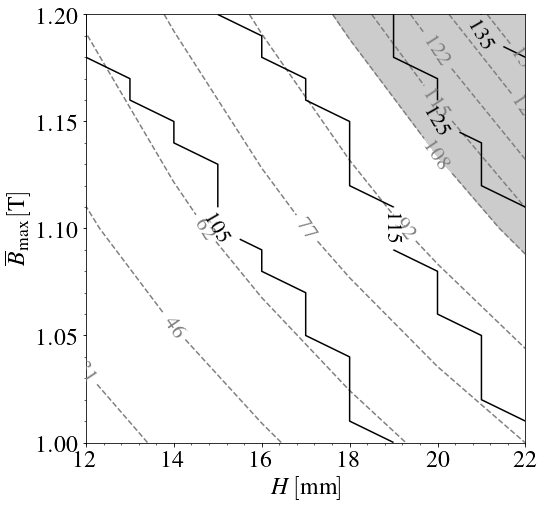

In [47]:
%matplotlib inline
fig_list_slope2D_35K = plot_Qc_and_Rs_contour()

It seems that an external radius of 120 mm can easily satisfy the target cooling capacity. We can select three operating points for three values of the magnetic field:

In [48]:
R_s_target_mm = 120
t_120 = filter_table_from_column(map_table,"R_s[mm]",R_s_target_mm)

In [49]:
B_h_values = np.array([1.1,1.15,1.20])

In [50]:
for B_h in B_h_values:
    
    t = filter_table_from_column(t_120,"B_max[T]",B_h)
    h_gap_max = np.max(t["h_gap[mm]"].values)
    H_reg_max = h_gap_max - 2e3*(FIXED_PARAMETERS_AMR["t_casing[m]"] + FIXED_PARAMETERS_AMR["t_air[m]"])
    print("For R_s = %d mm, B_max = %.2f T, the maximum regenerator height is %d mm" %(R_s_target_mm,B_h,H_reg_max))
    

For R_s = 120 mm, B_max = 1.10 T, the maximum regenerator height is 22 mm
For R_s = 120 mm, B_max = 1.15 T, the maximum regenerator height is 20 mm
For R_s = 120 mm, B_max = 1.20 T, the maximum regenerator height is 19 mm


For simulations of these points, comparing situations with and without the internal magnet (using an iron core instead), see the notebook `Comparison with and without the internal magnet.ipynb`.

To find the operating point for the point of $B_{\mathrm{max}} = 1.20\,\mathrm{T}$, we load the AMR simulation results and interpolate the values:

In [51]:
qc_map = pd.read_csv(QC_MAPS_FILE,sep='\t')
B_max_op_point = 1.20
qc_map_B = filter_table_from_column(qc_map,"Hmax[T]",B_max_op_point)
qc_map_B

,H[mm],Hmax[T],Test,Re_w[-],ReDp_CB[-],ReDp_HB[-],U_CB[-],U_HB[-],dPCB[kPa],dPHB[kPa],Tspan [K],dT_reg[K],Qc[W],Qh[W],Wpump[W],Wasco[W],Wmotor[W],COP[-],Q_wall-Loss[W]
2,10,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.669664,49.077647,46.291060,6.016106,20.16,6.350158,1.508862,-591.675271
5,12,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.739557,63.806365,62.602843,7.219327,20.16,8.255907,1.790541,-633.778998
8,14,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.795899,79.134803,79.595724,8.422548,20.16,10.239254,2.038411,-675.789513
11,16,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.842590,94.937258,97.125818,9.625770,20.16,12.283934,2.256666,-717.801504
14,18,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.882094,111.121220,115.092414,10.828991,20.16,14.377977,2.449386,-759.854209
17,20,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.916054,127.619766,133.416110,12.032212,20.16,16.512724,2.620264,-801.930894
20,22,1.2,Test1,0.0585,8.0137,8.0137,0.3977,0.3977,85.23524,-85.23524,35,35.945613,144.375459,152.038865,13.235433,20.16,18.680743,2.772390,-844.021700


In [52]:
H_reg_op_point = 19

fQc = interp1d(qc_map_B["H[mm]"].values,qc_map_B["Qc[W]"])
Qc_op_point = fQc(H_reg_op_point)

fCOP = interp1d(qc_map_B["H[mm]"].values,qc_map_B["COP[-]"])
COP_op_point = fCOP(H_reg_op_point)

T_H = FIXED_PARAMETERS_AMR["T_H[K]"]
T_C = T_H - FIXED_PARAMETERS_AMR["dT[K]"]

COP_Carnot_op_point = T_C / (T_H - T_C)

eta_2nd = COP_op_point / COP_Carnot_op_point

print("Operating point for the magnet:")
print("B_max = %.2f T" %(B_max_op_point))
print("H_reg = %d mm" %(H_reg_op_point))
print("***")
print("Performance:")
print("Q_c = %.1f W" %(Qc_op_point))
print("COP = %.1f" %(COP_op_point))
print("Second-law efficienct: %.1f %%" % (1e2*eta_2nd))



Operating point for the magnet:
B_max = 1.20 T
H_reg = 19 mm
***
Performance:
Q_c = 119.4 W
COP = 2.5
Second-law efficienct: 32.8 %
